In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

# Multivariate GRU

**Changes**:

* More layers
* More units
* More features

In [2]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

In [3]:
res_groups = {
    "60": ["B01", "B09", "B10"],
    "20": ["B05", "B06", "B07", "B8A", "B11", "B12"],
    "10": ["B02", "B03", "B04", "B08"],
}

In [4]:
def calc_ndvi(bands_data):
    return (bands_data['B08'] - bands_data['B04'])/(bands_data['B08'] + bands_data['B04'])

def calc_cvi(bands_data):
    """
    (𝐵𝑎𝑛𝑑8 ∗ 𝐵𝑎𝑛𝑑4) / (𝐵𝑎𝑛𝑑3)^2
    """
    return (bands_data['B08'] * bands_data['B04']) / (bands_data['B03']**2)

def calc_datt1(bands_data):
    """
    𝐵𝑎𝑛𝑑8 − 𝐵𝑎𝑛𝑑5 / 𝐵𝑎𝑛𝑑8 − 𝐵𝑎𝑛𝑑4
    """
    return (bands_data['B08'] - bands_data['B05'])/(bands_data['B08'] - bands_data['B04'])

def calc_evi(bands_data):
    """
    2.5* (𝐵𝑎𝑛𝑑8 − 𝐵𝑎𝑛𝑑4) / (𝐵𝑎𝑛𝑑8 + 6 ∗ 𝐵𝑎𝑛𝑑4 − 7.5 ∗ 𝐵𝑎𝑛𝑑2 + 1)
    """
    return 2.5* (bands_data['B08'] - bands_data['B04']) / (bands_data['B08'] + 6*bands_data['B04'] - 7.5 * bands_data['B02'] + 1)

def calc_arvi2(bands_data):
    return -0.18 + 1.17 * calc_ndvi(bands_data)


vi_methods = [
    'ndvi',
    'cvi',
    'evi',
    'arvi2',
#     'datt1',
]

In [5]:
# Number of time stamps
N_ts = 11

# Number of bands
N_b = 10

VALID_AGG_METHODS = ['mean','median','min','max','std']


def load_for_id(farm_id, dataset, bands_subset=None):
    """
    Load all data for a farm
    
    Return:
    
    dictionary: {band: {date: ndarray}, {...}}
    """
    farm_dir = interim_data_dir / 'masks_v2' / dataset / str(farm_id)

    dates = farm_dir.glob('*/')
    farm_data = {}
    
    for date_path in dates:
        
        date = date_path.stem

        bands = date_path.glob("*.npy")
        
        farm_data[date_path.stem] = {}
        
        for band_path in bands:
            band = band_path.stem
            
            if bands_subset and band in bands_subset:
                arr = np.load(band_path)
                farm_data[date][band] = arr
            else:
                arr = np.load(band_path)
                farm_data[date][band] = arr
        
    return farm_data

def agg_arr(arr, agg_method):
    """
    aggregate an array with a nan-aware numpy method
    """
    assert agg_method in VALID_AGG_METHODS
    return eval(f'np.nan{agg_method}')(arr.flatten())

def calc_vi_ts(farm_data, farm_id, agg_methods, which_vi='ndvi'):
    """
    Calculate vegetation index time series for a farm
    """
    vi_data = {}
    for date, bands_data in farm_data.items():
        # Get aggregated statistics of VI signals for this date
        vi_data[date] = [agg_arr(eval(f'calc_{which_vi}')(bands_data), agg_method) for agg_method in agg_methods]
        
    vi = pd.DataFrame.from_dict(vi_data, orient='index')
    vi.index = pd.to_datetime(vi.index)
    vi.index.name='time'
    vi.columns = [f'{which_vi}_{agg_method}' for agg_method in agg_methods]
    
    return pd.concat([vi], keys=[farm_id], names=['farm_id'])

def create_features_dataset(dataset='train', bands_subset=None, agg_methods=['mean','median'], limit_farms=None):
    """
    
    """
    
    shp_df = read_shapefile(dataset)
    
    ids_list = shp_df.index.to_list()
    
    if limit_farms:
        ids_list = ids_list[:limit_farms]

    vi_dfs = []
    for farm_id in tqdm(ids_list, "farms"):
        
        farm_data = load_for_id(farm_id, dataset, bands_subset=bands_subset)
        
        vi_data = [calc_vi_ts(farm_data, farm_id, agg_methods, vi_method) for vi_method in vi_methods]

        vi_df = pd.concat(vi_data, axis=1)

        vi_dfs.append(vi_df)

    df = pd.concat(vi_dfs, axis=0).reset_index()
    
    if dataset=='train':
        df = df.join(shp_df[['y']], on='farm_id')
        
    df.time = pd.to_datetime(df.time)
    
    # Sort each farm by time
    df = df.sort_values(by=['farm_id','time'])
    
    # After sorting the index will be jumbled, lets throw that away
    df.reset_index(drop=True, inplace=True)
    
    return df
    
    

In [6]:
train_features_df = create_features_dataset(
    dataset='train',
    bands_subset=['B02','B03','B04','B08'],
    agg_methods=['min','mean','median','std','max']
)

farms: 100%|██████████| 2494/2494 [05:14<00:00,  7.95it/s]


In [7]:
test_features_df = create_features_dataset(
    dataset='test', 
    bands_subset=['B02','B03','B04','B08'],
    agg_methods=['min','mean','median','std','max']
)

farms: 100%|██████████| 1074/1074 [02:22<00:00,  7.30it/s]


In [8]:
def impute_nan_inf(df):
    """
    Impute bad values (nan and inf) using
    the median of that feature on that time stamp
    for all farms
    
    TODO: This can be improved
    """
    
    # replace all nans variants with np.nan
    df = df.replace([np.nan, None, np.inf, -np.inf], np.nan)

    # replace all nans with the median value of all farms on that timestamp
    for ts, ts_df in df.groupby('time'):
        df.loc[ts_df.index] = ts_df.fillna(ts_df.median())
        
    return df
        
train_features_df = impute_nan_inf(train_features_df)
test_features_df = impute_nan_inf(test_features_df)

train_features_df.head()

,farm_id,time,ndvi_min,ndvi_mean,ndvi_median,ndvi_std,ndvi_max,cvi_min,cvi_mean,cvi_median,...,evi_mean,evi_median,evi_std,evi_max,arvi2_min,arvi2_mean,arvi2_median,arvi2_std,arvi2_max,y
0,1,2017-01-01,0.454174,0.671766,0.692653,0.065668,0.745895,0.001221,3.001651,0.947159,...,2.474928,0.0,2.691551,6.758784,0.351384,0.605966,0.630404,0.076831,0.692697,Vineyard
1,1,2017-01-31,0.586915,0.718396,0.729027,0.046242,0.781602,0.047159,2.744553,1.052384,...,2.208423,0.0,2.330548,5.673348,0.506691,0.660523,0.672961,0.054103,0.734474,Vineyard
2,1,2017-02-10,0.633239,0.746055,0.755768,0.038175,0.798810,0.031403,1.977070,1.065654,...,2.510243,0.0,2.629651,5.792201,0.560890,0.692884,0.704249,0.044665,0.754608,Vineyard
3,1,2017-03-12,0.514993,0.668629,0.684211,0.065733,0.765019,0.003610,2.180335,0.865489,...,3.435664,0.0,3.770609,11.882745,0.422541,0.602296,0.620526,0.076907,0.715073,Vineyard
4,1,2017-03-22,0.511155,0.659258,0.673052,0.055294,0.747845,0.010952,2.783775,1.226074,...,4.197762,0.0,4.720135,14.271617,0.418052,0.591332,0.607470,0.064695,0.694979,Vineyard


## Save to disk

In [11]:
from config import processed_data_dir

dataset_version = 'v1'

out_dir = processed_data_dir / 'VI_datasets' / dataset_version

train_features_df.to_csv(out_dir/'train.csv')
test_features_df.to_csv(out_dir/'test.csv')

# Option to start from here

In [65]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

from config import processed_data_dir

dataset_version = 'v1'

train_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'train.csv', index_col=0)
test_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'test.csv', index_col=0)

train_features_df.head()

,farm_id,time,ndvi_min,ndvi_mean,ndvi_median,ndvi_std,ndvi_max,cvi_min,cvi_mean,cvi_median,...,evi_mean,evi_median,evi_std,evi_max,arvi2_min,arvi2_mean,arvi2_median,arvi2_std,arvi2_max,y
0,1,2017-01-01,0.454174,0.671766,0.692653,0.065668,0.745895,0.001221,3.001651,0.947159,...,2.474928,0.0,2.691551,6.758784,0.351384,0.605966,0.630404,0.076831,0.692697,Vineyard
1,1,2017-01-31,0.586915,0.718396,0.729027,0.046242,0.781602,0.047159,2.744553,1.052384,...,2.208423,0.0,2.330548,5.673348,0.506691,0.660523,0.672961,0.054103,0.734474,Vineyard
2,1,2017-02-10,0.633239,0.746055,0.755768,0.038175,0.798810,0.031403,1.977070,1.065654,...,2.510243,0.0,2.629651,5.792201,0.560890,0.692884,0.704249,0.044665,0.754608,Vineyard
3,1,2017-03-12,0.514993,0.668629,0.684211,0.065733,0.765019,0.003610,2.180335,0.865489,...,3.435664,0.0,3.770609,11.882745,0.422541,0.602296,0.620526,0.076907,0.715073,Vineyard
4,1,2017-03-22,0.511155,0.659258,0.673052,0.055294,0.747845,0.010952,2.783775,1.226074,...,4.197762,0.0,4.720135,14.271617,0.418052,0.591332,0.607470,0.064695,0.694979,Vineyard


## Normalize Features Dataset

Neural Nets are sensitive to scale, but we want to keep the variance in the features. So we will MinMax scale each feature on a specific time step over all farms. 

I.e - the network will see any number of variables at a time, but all of them will be on the same scale (0 - 1) and the variance between farms will be kept the same. 

In [66]:
# Make copies to compare before / after normalization
train_copy = train_features_df.copy()
test_copy = test_features_df.copy()

In [67]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

times = train_features_df['time'].unique()
feature_cols = feature_cols = [col for col in test_features_df.columns if col not in ['farm_id','time']]

for ts in times:
    scaler = StandardScaler()
    
    train_ts_df = train_copy[train_copy.time == ts]
    test_ts_df = test_copy[test_copy.time == ts]
    
    train_features_df.loc[train_ts_df.index, feature_cols] = scaler.fit_transform(train_ts_df[feature_cols])
    test_features_df.loc[test_ts_df.index, feature_cols] = scaler.transform(test_ts_df[feature_cols])

## Transform Dataset for MVTS Classification

In [68]:
def transform_dataset(features_df):
    """
    Create a data array in the shape (n_ids, n_time, n_features)
    
    If it is the training set, also return dictionary mapping index
    in dataset to correct label.
    
    """
    
    n_ids = features_df.farm_id.nunique()

    feature_cols = [col for col in features_df.columns if col not in ['farm_id','y','time']]
    
    n_features = len(feature_cols)

    data = np.ndarray((n_ids, 11, n_features))
    
    classes = {}
    for i, (farm_id, farm_df) in enumerate(features_df.groupby(['farm_id'])):

        data[i,:,:] = farm_df[feature_cols].values
        
        if 'y' in features_df.columns:
            c = farm_df['y'].unique()
            classes[i] = c[0]
            
    return data, classes
    

In [69]:
train_data, train_labels_dict = transform_dataset(train_features_df)
test_data, _ = transform_dataset(test_features_df)

print('Train data:\t\t',train_data.shape)
print('Test data:\t\t',test_data.shape)

Train data:		 (2494, 11, 20)
Test data:		 (1074, 11, 20)


In [70]:
test_features_df.head(11)

,farm_id,time,ndvi_min,ndvi_mean,ndvi_median,ndvi_std,ndvi_max,cvi_min,cvi_mean,cvi_median,...,evi_min,evi_mean,evi_median,evi_std,evi_max,arvi2_min,arvi2_mean,arvi2_median,arvi2_std,arvi2_max
0,5,2017-01-01,0.237425,0.934584,1.040139,0.826581,0.902304,-0.412871,-0.855922,0.827375,...,0.128539,-0.103433,-0.508431,-0.107558,-0.109262,0.237425,0.934584,1.040139,0.826581,0.902304
1,5,2017-01-31,0.294448,0.958399,1.058548,0.380839,0.933470,-0.107844,-0.704432,-0.380853,...,0.141915,-0.294645,-0.587311,-0.156377,-0.129923,0.294448,0.958399,1.058548,0.380839,0.933470
2,5,2017-02-10,0.448063,0.853515,0.975023,-0.104560,-0.024861,-0.348765,-0.631042,-0.340280,...,0.291059,-0.283331,-0.483158,-0.352950,-0.286323,0.448063,0.853515,0.975023,-0.104560,-0.024861
3,5,2017-03-12,0.220821,1.050426,1.176940,0.701041,1.014793,-0.285727,-0.628832,0.416531,...,0.341461,0.258834,-0.415968,-0.222666,-0.111946,0.220821,1.050426,1.176940,0.701041,1.014793
4,5,2017-03-22,0.631860,0.479592,0.530700,-0.103879,0.272400,-0.146718,-0.869733,-1.161328,...,0.455738,-0.124687,-0.355363,-0.521995,-0.425758,0.631860,0.479592,0.530700,-0.103879,0.272400
5,5,2017-05-31,0.804810,0.358630,0.369820,-0.067880,-0.003175,-0.430996,-0.318639,0.831300,...,0.054369,0.010884,-0.137474,-0.241849,-0.318140,0.804810,0.358630,0.369820,-0.067880,-0.003175
6,5,2017-06-20,0.872033,0.183019,0.295335,-0.033986,-0.013913,-0.324155,-1.019531,-0.792059,...,0.250324,0.104895,-0.322810,-0.207301,-0.087576,0.872033,0.183019,0.295335,-0.033986,-0.013913
7,5,2017-07-10,0.514635,0.063523,0.311542,-0.035488,-0.026925,-0.333003,0.141012,-0.247812,...,0.270318,1.153922,-0.165337,0.945248,1.658864,0.514635,0.063523,0.311542,-0.035488,-0.026925
8,5,2017-07-15,0.369848,0.013592,0.019472,-0.041306,-0.041013,-0.139000,1.520874,0.170412,...,0.244006,-0.098108,-0.333553,-0.291991,-0.233929,0.369848,0.013592,0.019472,-0.041306,-0.041013
9,5,2017-08-04,-0.632632,-0.124783,-0.110993,-0.039483,-0.072652,0.397103,-0.240705,1.389598,...,-0.057094,-0.379961,-0.311903,-0.014366,-0.077540,-0.632632,-0.124783,-0.110993,-0.039483,-0.072652


## Start Modelling Process

### Create validation set

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Copy for later
data = train_data.copy()

train_labels = list(train_labels_dict.values())
train_indexes = list(train_labels_dict.keys())
train_idx, val_idx, train_labels, val_labels = train_test_split(train_indexes, train_labels, stratify=train_labels)

le = LabelEncoder()
train_labels_enc = le.fit_transform(np.array(train_labels).reshape(-1,1))
val_labels_enc = le.transform(np.array(val_labels).reshape(-1,1))

train_data = data[train_idx,:, :]
val_data = data[val_idx,:, :]

print('train data : ',train_data.shape)
print('val data : ',val_data.shape)

train data :  (1870, 11, 20)
val data :  (624, 11, 20)


### Create model

In [93]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from src.visualization.tf_viz import PlotLosses

es = EarlyStopping(monitor='val_loss', verbose=1, patience=50)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=50, verbose=1)

plot_losses = PlotLosses()

def get_model(n_features):

    model = models.Sequential()
    model.add(layers.GRU(8, input_shape=(11, n_features), return_sequences=True, dropout=0.2))
#     model.add(layers.GRU(16, dropout=0.2))
    model.add(layers.Flatten())
#     model.add(layers.Dense(16,activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)))
    model.add(layers.Dense(9, activation='softmax'))
    
    return model



model = get_model(train_data.shape[-1])
# optimizer = keras.optimizers.Adam(learning_rate=0.003)
optimizer = keras.optimizers.RMSprop()
model.compile(optimizer=optimizer,
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 11, 8)             720       
_________________________________________________________________
flatten_8 (Flatten)          (None, 88)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 801       
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________


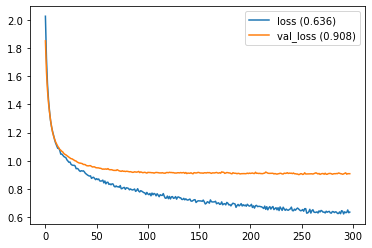


Epoch 00298: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1870/1870 - 0s - loss: 0.6359 - sparse_categorical_crossentropy: 0.6359 - val_loss: 0.9083 - val_sparse_categorical_crossentropy: 0.9083
Epoch 00298: early stopping


In [94]:
# class_weight = 1- pd.Series(all_labels).value_counts(normalize=True)
class_weight = 1-train_features_df.y.value_counts(normalize=True)

model.fit(train_data, 
          train_labels_enc,
          batch_size=64,
          validation_data=(val_data, val_labels_enc), 
          class_weight=class_weight,
          verbose=2,
          epochs=2000,
          callbacks=[plot_losses, es, reduce_lr])

In [95]:
from sklearn.metrics import log_loss

val_preds = model.predict(val_data)
train_preds = model.predict(train_data)
print('val loss: ',log_loss(val_labels_enc, val_preds))
print('train loss: ',log_loss(train_labels_enc, train_preds))

val loss:  0.9083398564752059
train loss:  0.5317487490786592


### Confusion matrix

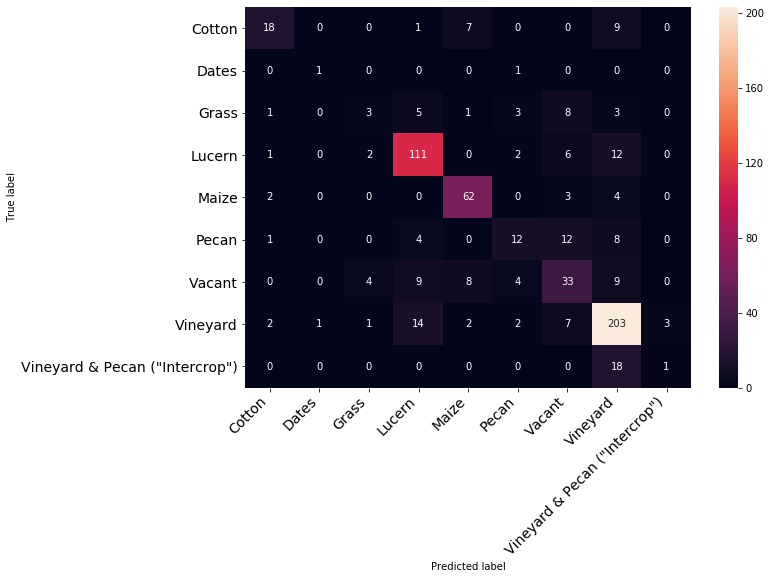

In [96]:
from sklearn.metrics import confusion_matrix
from src.visualization.visualize import print_confusion_matrix

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0).sort_index().crop

val_preds = model.predict_classes(val_data)


cm = confusion_matrix(val_labels_enc, val_preds)
print_confusion_matrix(cm, class_names=class_labels);

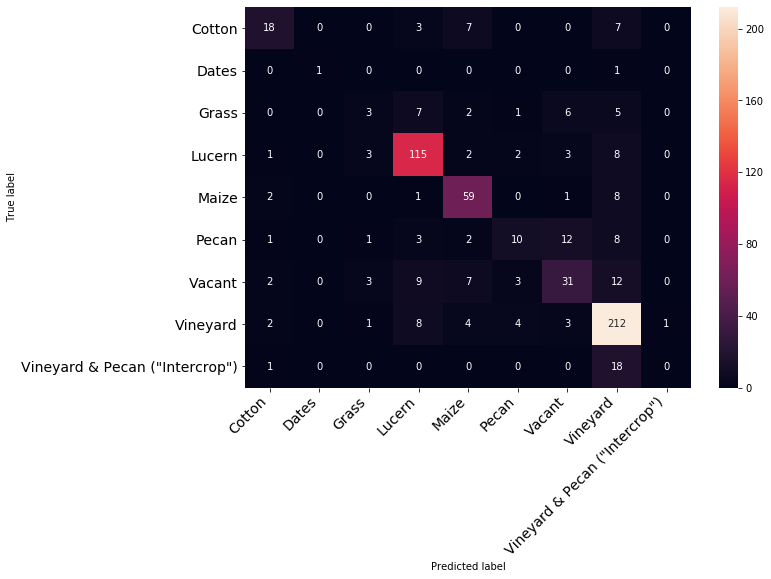

In [82]:
from sklearn.metrics import confusion_matrix
from src.visualization.visualize import print_confusion_matrix

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0).sort_index().crop

val_preds = model.predict_classes(val_data)

cm = confusion_matrix(val_labels_enc, val_preds)
print_confusion_matrix(cm, class_names=class_labels);

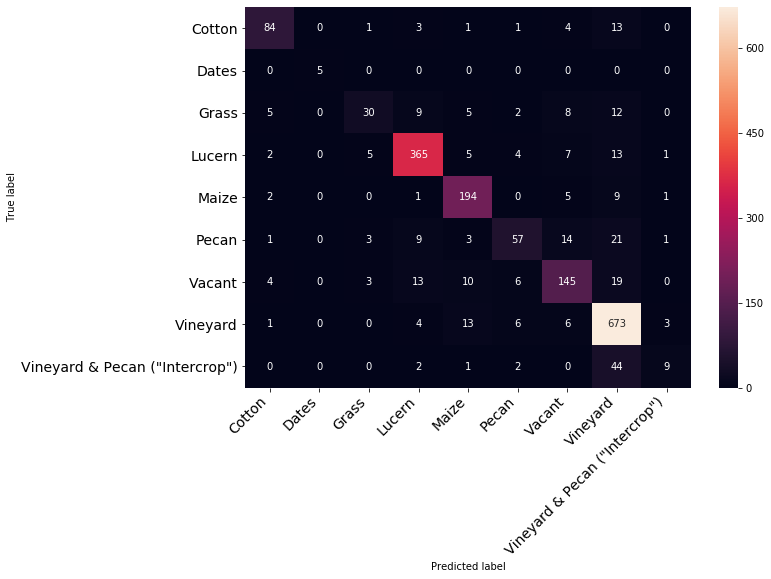

In [83]:
train_preds = model.predict_classes(train_data)

cm = confusion_matrix(train_labels_enc, train_preds)
print_confusion_matrix(cm, class_names=class_labels);

## Make Submission

### First retrain on all data


In [104]:
all_data = np.vstack([train_data, val_data])
all_labels = np.array(list(train_labels_enc) + list(val_labels_enc))

class_weight = (1 - pd.Series(all_labels).value_counts(normalize=True)).to_dict()
class_weight

{7: 0.6226944667201283,
 3: 0.785084202085004,
 4: 0.8865276663993584,
 6: 0.8929430633520449,
 5: 0.9414595028067362,
 0: 0.9430633520449078,
 2: 0.9619085805934242,
 8: 0.9691259021651965,
 1: 0.9971932638331997}

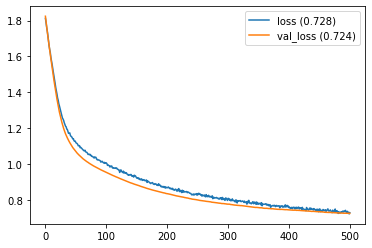

2244/2244 - 0s - loss: 0.7279 - sparse_categorical_crossentropy: 0.8664 - val_loss: 0.7241 - val_sparse_categorical_crossentropy: 0.8585
Epoch 502/2000


KeyboardInterrupt: 

In [106]:
model = get_model(all_data.shape[-1])
model.compile(optimizer=optimizer,
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

model.fit(all_data, 
          all_labels,
          batch_size=64, 
          verbose=2,
          validation_split=0.1,
          epochs=2000, 
          class_weight=class_weight,
          callbacks=[plot_losses, es, reduce_lr])

In [107]:
def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = model.predict(test_data)
test_ids = sorted(list(test_features_df.farm_id.unique()))
sub_df = make_sub(predictions, test_ids)
sub_df.head()

,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
field_id,,,,,,,,,
5,0.021072,0.000046,0.007290,0.034192,0.004035,0.020171,0.001897,0.827615,0.083684
6,0.013955,0.000105,0.018596,0.042968,0.018943,0.059844,0.007798,0.724836,0.112956
10,0.011550,0.000086,0.006247,0.021710,0.003190,0.012255,0.002374,0.846929,0.095660
18,0.021330,0.000321,0.010749,0.017735,0.002709,0.031882,0.011644,0.852371,0.051259
23,0.008079,0.000716,0.014713,0.004239,0.008503,0.039126,0.008763,0.829489,0.086372


In [108]:
from config import subs_dir

sub_df.to_csv(subs_dir / 'gru_vi_v1_2.csv')

In [46]:
nans = lambda df: df[df.isnull().any(axis=1)]

nans(sub_df.fillna(sub_df.mean()))

,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
field_id,,,,,,,,,
